# Strain mapping of experimental Si/SiGe stacks using correlation approach

These notebooks measure the strain fields of a experimental 4D-STEM dataset which consists of alternating $Si / Si_{0.82}Ge_{0.18}$ multilayer stacks, on a $Si$ substrate, using correlation based approach in py4DSTEM library. The average thickness of the sample is approx. 110 nm as measured form the pure $Si$ region. This tutorial uses the downsampled version of this dataset.

[Downsampled Si/SiGe multilayer experimental dataset](https://drive.google.com/file/d/1fXNYSGpe6w6E9RBA-Ai_owZwoj3w8PNC/view?usp=sharing) (1.2 GB)

[Downsampled vacuum probe](https://drive.google.com/file/d/141Tv0YF7c5a-MCrh3CkY_w4FgWtBih80/view?usp=sharing)

[Estimated Vegard's law strain from EELS composition](https://drive.google.com/file/d/1klkecq8IuEOYB-bXchO7RqOcgCl4bmDJ/view?usp=sharing)

### Acknowledgements

This tutorial was created by the py4DSTEM instructor team:
- Stephanie Ribet (sribet@u.northwestern.edu)
- Ben Savitzky (bhsavitzky@lbl.gov)
- Steve Zeltmann (steven.zeltmann@berkeley.edu)
- Alex Rakowski (arakowski@lbl.gov)
- Colin Ophus (clophus@lbl.gov)

Experimental data was collected by Steve Zeltmann (steven.zeltmann@berkeley.edu)

In [1]:
# Required Libraries
import numpy as np
import py4DSTEM
print('py4DSTEM: {}'.format(py4DSTEM.__version__))

py4DSTEM: 0.13.6


# Load data

In [2]:
#Load the datacubes using py4DSTEM
# C:\data

# file_path_data = r'C:\data\4DSTEM\tutorial\downsample_Si_SiGe_exp.h5'
# file_path_probe = r'C:\data\4DSTEM\tutorial\downsample_Si_SiGe_probe.h5'
# file_path_analysis = r'C:\data\4DSTEM\tutorial\downsample_Si_SiGe_analysis_'
# file_path_compare = r'C:\data\4DSTEM\tutorial\Si_SiGe_EELS_strain.mat'
file_path_data = '/media/cophus/DataSSD1/data/downsample_Si_SiGe_exp.h5'
file_path_probe = '/media/cophus/DataSSD1/data/downsample_Si_SiGe_probe.h5'
file_path_analysis = '/media/cophus/DataSSD1/data/downsample_Si_SiGe_analysis_'
file_path_compare = '/media/cophus/DataSSD1/data/Si_SiGe_EELS_strain.mat'

In [3]:
dataset = py4DSTEM.read(file_path_data, data_id='datacube_0')
dataset_probe = py4DSTEM.read(file_path_probe, data_id='datacube_0')

In [4]:
print(dataset.data.shape)
print(dataset_probe.data.shape)

(50, 200, 128, 128)
(1, 1, 128, 128)


# Examine the data 

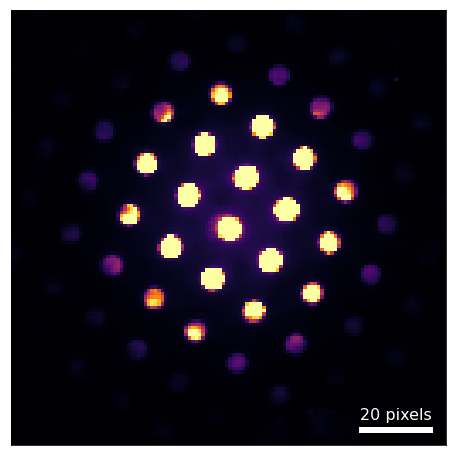

In [5]:
# Plot the mean diffraction pattern
dataset.get_dp_mean();

py4DSTEM.show(
    dataset.tree['dp_mean'],
    clipvals='manual',
    min = 0,
    max = 10,
    cmap='inferno'
)

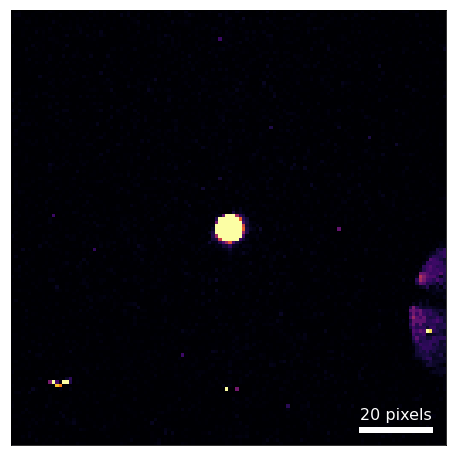

In [6]:
# Generate the mean probe
dataset_probe.get_dp_mean();

# Plot the mean Probe
py4DSTEM.show(
    dataset_probe.tree['dp_mean'],
    clipvals = 'manual',
    min = 0.0,
    max = 0.0001,
    cmap = 'inferno',
)

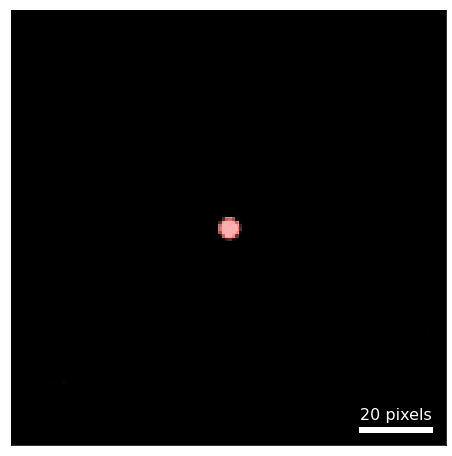

Estimated probe radius = 2.97 pixels


In [7]:
# Estimate the radius of the BF disk, and the center coordinates
probe_semiangle, probe_qx0, probe_qy0 = dataset_probe.get_probe_size()

# plot the mean diffraction pattern, with the estimated probe radius overlaid as a circle
py4DSTEM.visualize.show_circles(
    dataset_probe.tree['dp_mean'], 
    (probe_qx0, probe_qy0), 
    probe_semiangle,
)

# Print the estimate probe radius
print('Estimated probe radius =', '%.2f' % probe_semiangle, 'pixels')

In [8]:
# Next, create a BF virtual detector using the center beam position (qx0, qy0), and a virtual DF detector.
# The DF virtual detector can be set to all remaining pixels.

expand_BF = 4.0

center = (probe_qx0, probe_qy0)
radius = probe_semiangle + expand_BF


dataset.get_virtual_image(
    mode = 'circle',
    geometry = (center,radius),
    name = 'bright_field',
)


radii = (probe_semiangle + expand_BF, 1e3)

dataset.get_virtual_image(
    mode = 'annulus',
    geometry = (center,radii),
    name = 'dark_field',
);

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 25553.68it/s]


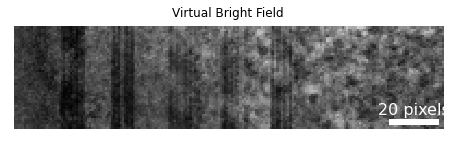

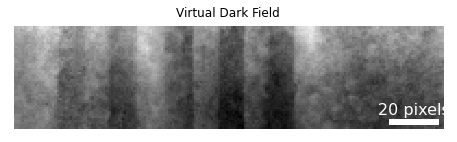

In [9]:
py4DSTEM.show(
    dataset.tree['bright_field'],
    figsize=(16,2),
    bordercolor = 'w',
    cmap='gray',
    title='Virtual Bright Field',
)
py4DSTEM.show(
    dataset.tree['dark_field'],
    figsize=(16,2),
    bordercolor = 'w',
    cmap = 'gray',
    title='Virtual Dark Field',
)

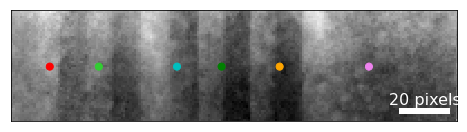

In [10]:
# Choose some diffraction patterns to use for hyperparameter tuning

rxs = 25, 25, 25, 25, 25, 25
rys = 17, 39, 74, 94, 120, 160
colors=['r','limegreen','c','g','orange', 'violet']

py4DSTEM.visualize.show_points(
    dataset.tree['dark_field'],
    x=rxs,
    y=rys,
    pointcolor=colors,
    figsize=(8,8)
)

# Construct probe template

In [11]:
probe = dataset_probe.get_vacuum_probe()

0it [00:00, ?it/s]


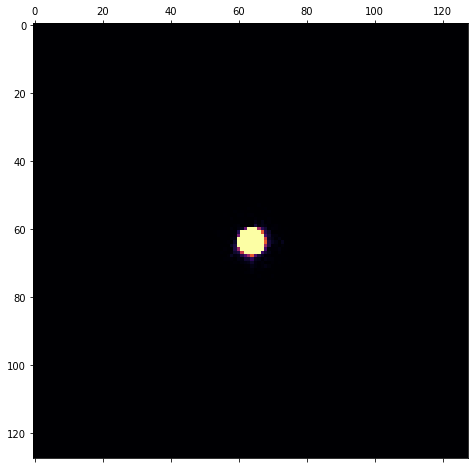

In [12]:
py4DSTEM.show(
    dataset_probe.tree['probe'].probe,
    clipvals = 'manual',
    min = 0.0,
    max = 0.0001,
    cmap='inferno',
)

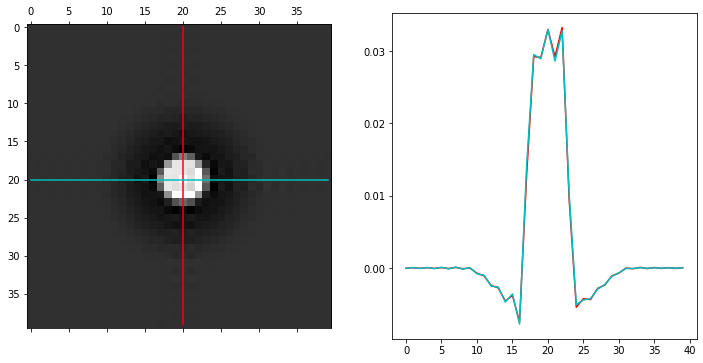

In [13]:
probe_kernel = probe.get_kernel(
    mode = 'sigmoid',
    radii = (probe_semiangle * 1.0, probe_semiangle * 4.0)
)

py4DSTEM.visualize.show_kernel(
    probe_kernel,
    R = 20,
    L = 20,
    W = 1
)

# Find Bragg Peaks

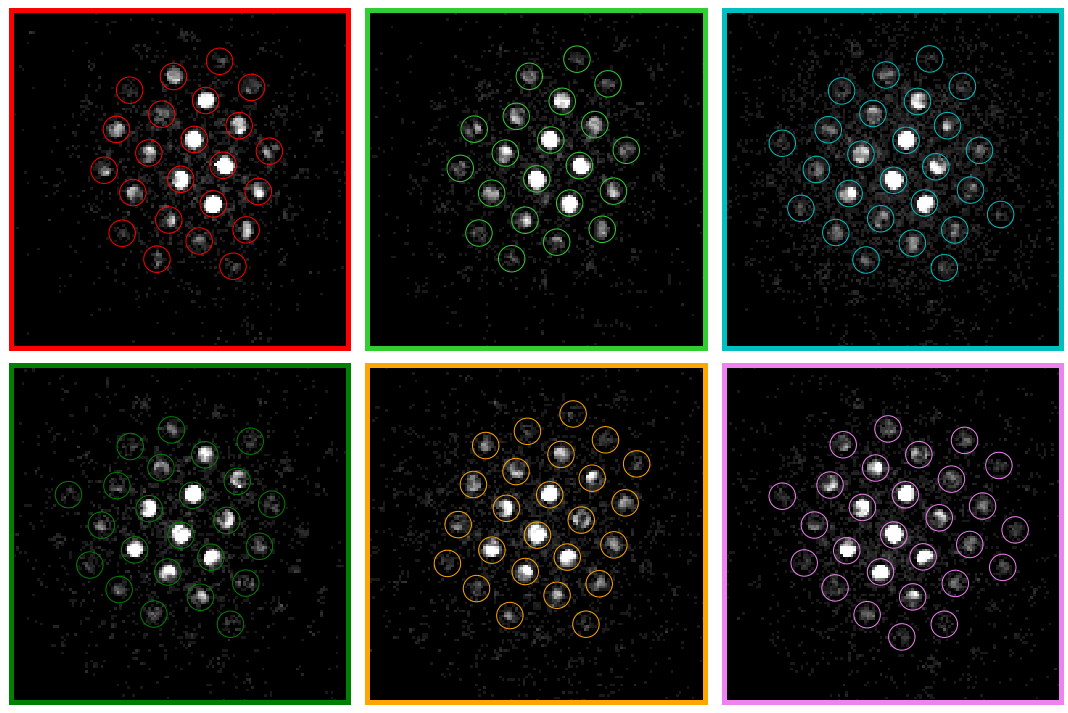

In [14]:
# Test hyperparameters on a few probe positions
# Visualize the diffraction patterns and the located disk positions


# Hyperparameters
detect_params = {
    'corrPower': 1.0,
    'sigma': 0,
    'edgeBoundary': 16,
    'minRelativeIntensity': 0,
    'minAbsoluteIntensity': 1,
    'minPeakSpacing': 8,
    'subpixel': 'poly',
    # 'subpixel' : 'multicorr',
    'upsample_factor': 8,
    'maxNumPeaks': 1000,
#     'CUDA': True,
}

disks_selected = dataset.find_Bragg_disks(
    data = (rxs, rys),
    template = probe_kernel,
    **detect_params,
)

py4DSTEM.visualize.show_image_grid(
    get_ar = lambda i:dataset.data[rxs[i],rys[i],:,:],
    H=2, 
    W=3,
    axsize=(5,5),
    clipvals='manual',
    vmin=0,
    vmax=100,
    scaling='power',
    power=0.5,
    get_bordercolor = lambda i:colors[i],
    get_x = lambda i: disks_selected[i].data['qx'],
    get_y = lambda i: disks_selected[i].data['qy'],
    get_pointcolors = lambda i: colors[i],
    open_circles = True,
    scale = 700,
)

In [15]:
# Find Bragg peaks in all probe positions.
# Note that "poly" subpixel fitting can be used to keep this tutoral fast, but "multicorr" is more accurate. 
# We strongly recommend the use of subpixel="multicorr" for strain mapping!

bragg_peaks = dataset.find_Bragg_disks(
    template = probe_kernel,
    **detect_params,
)

Finding Bragg Disks: 100%|██████████████████████████████████████████████████████████| 10.0k/10.0k [00:34<00:00, 292DP/s]


# Save the peak data

In [16]:
# Save Bragg disk locations
file_name_braggdisks_raw = file_path_analysis + 'braggdisks_raw.h5'

In [17]:
# Save Bragg disk positions
py4DSTEM.save(
    file_name_braggdisks_raw,
    bragg_peaks,
    mode='o',
)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5237.82it/s]


# Load the peak data

In [18]:
# This step is optional, but can serve as a checkpoint in the analysis
file_name_braggdisks_raw = file_path_analysis + 'braggdisks_raw.h5'
py4DSTEM.io.print_h5_tree(file_name_braggdisks_raw)

/
|--4DSTEM
	|--braggvectors
		|--_v_uncal
		|--calibration




In [19]:
bragg_peaks = py4DSTEM.read(
    file_name_braggdisks_raw, 
    root = '4DSTEM/braggvectors'
)
bragg_peaks

Reading PointListArray: 100%|████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5777.61PointList/s]


BraggVectors( A (50, 200)-shaped array of lists of bragg vectors )

# Center coordinate system

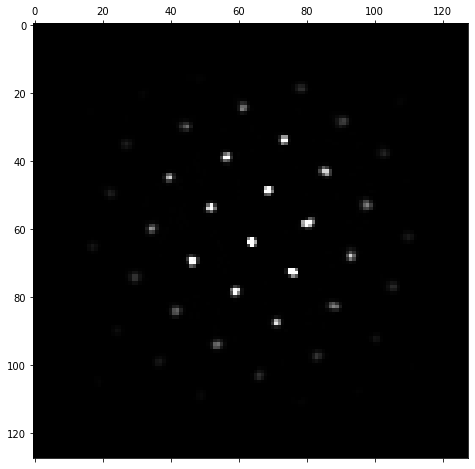

In [20]:
# Compute a Bragg vector map (BVM), a 2D histogram of the Bragg peak positions, weighted by their correlation intensities
bragg_peaks.get_bvm(mode = 'raw')

# Plot the BVM
bvm_vis_params = {
    'scaling':'power',
    'power':0.5,
    'clipvals':'manual',
    'vmin':0,
    'vmax':1e5
}
py4DSTEM.show(
    bragg_peaks.bvm_raw,
    **bvm_vis_params
)

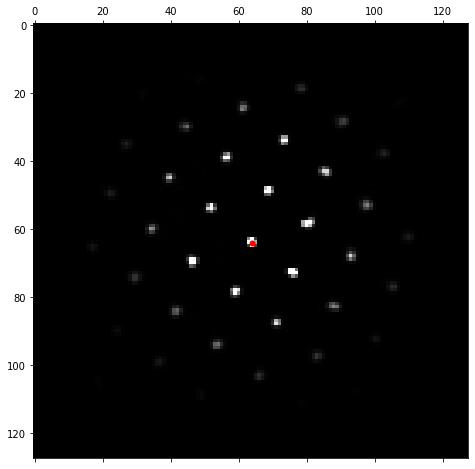

In [21]:
# Specify an annular region of Q-space 
center_guess = 64, 64

py4DSTEM.show(
    bragg_peaks.bvm_raw,
    points = {'x':center_guess[0],'y':center_guess[1]},
    **bvm_vis_params,
)

In [22]:
# Compute the origin position pattern-by-pattern
origin_meas = bragg_peaks.measure_origin(
    mode = 'no_beamstop',
    center_guess = center_guess,
)

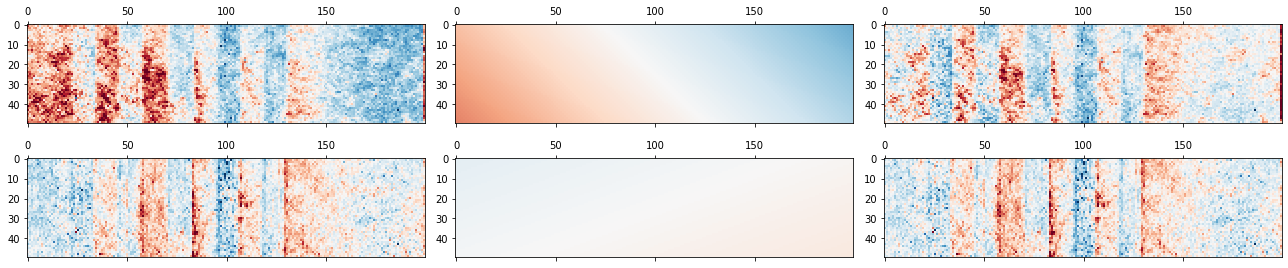

In [23]:
# Some local variation in the position of the origin due to electron-sample interaction is
# expected, and constitutes meaningful signal that we would not want to subtract away.
# In fitting a plane or parabolic surface to the measured origin shifts, we aim to
# capture the systematic shift of the beam due to the changing scan coils,
# while removing as little physically meaningful signal we can.

qx0_fit,qy0_fit,qx0_residuals,qy0_residuals = bragg_peaks.fit_origin()

In [24]:
# Center the disk positions about the origin
bragg_peaks.calibrate()

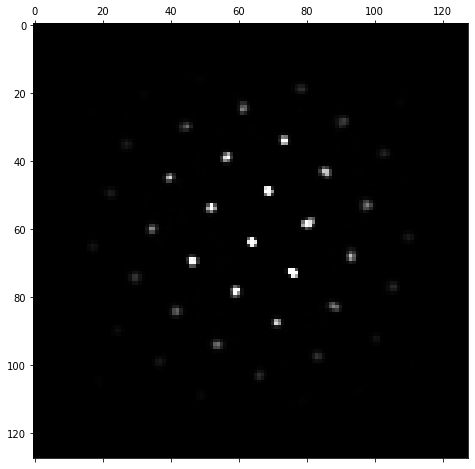

In [25]:
# Compute and plot the centered Bragg vector map

# Compute the Bragg vector map
bragg_peaks.get_bvm(mode = 'centered')

# plot the Bragg vector map
py4DSTEM.show(
    bragg_peaks.bvm_centered,
    **bvm_vis_params,
)

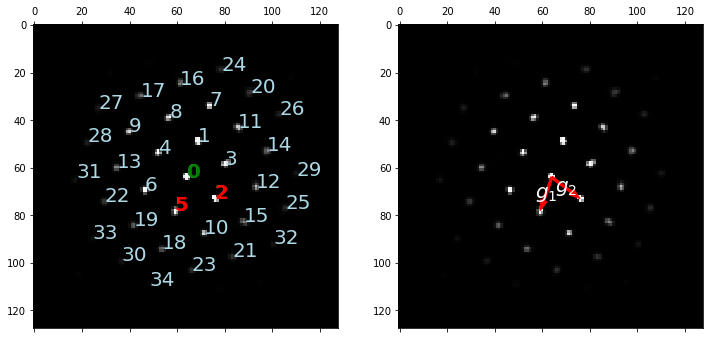

In [26]:
bragg_peaks.choose_lattice_vectors(
    0,
    5,
    2,
    sigma=0, 
    minSpacing=13,
    minAbsoluteIntensity=1e2,
    maxNumPeaks=100,
#     subpixel='multicorr',
    bvm_vis_params = bvm_vis_params,
)

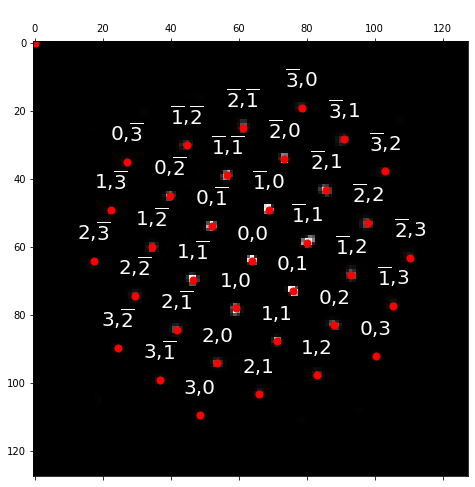

In [27]:
bragg_peaks.index_bragg_directions(bvm_vis_params = bvm_vis_params)

In [28]:
# maximum peak spacing from expected positions
max_peak_spacing = 2

# add the lattice indices to all Bragg peaks
bragg_peaks.add_indices_to_braggpeaks(
    maxPeakSpacing = max_peak_spacing,
)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1684.67it/s]


In [29]:
# loop through all probe positions and find the best fit lattice
bragg_peaks.fit_lattice_vectors_all_DPs()

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 3441.40it/s]


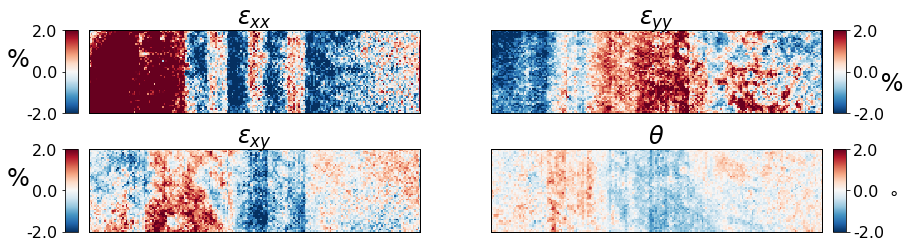

In [30]:
# To calculate strain, we need to find how lattice vector changes from a reference region.

# Initially, we will define the reference region to be all pixels, and compute the strain
mask = np.ones((bragg_peaks.shape[0],bragg_peaks.shape[1]),dtype=bool)
bragg_peaks.get_strain_from_reference_region(mask = mask )

# Calculate the strain maps, referenced to the median lattice vectors of all probe positions
strainmap_median = bragg_peaks.get_rotated_strain_map(mode = 'median')

# plot the 4 components of the strain tensor
py4DSTEM.visualize.show_strain(
    strainmap_median,
    vrange_exx = [-2.0, 2.0],
    vrange_theta = [-2.0, 2.0],
    ticknumber = 3,
    axes_plots = (),
    bkgrd = False,
    figsize = (14,4)
)

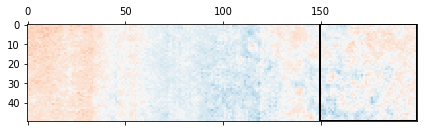

In [31]:
# Choose a reference lattice location to be the probe positions inside the substrate.
x0,xf = 0,50
y0,yf = 150, 200

py4DSTEM.show(
    strainmap_median.get_slice('e_yy').data,              
    mask = mask,
    figsize = (7, 20), 
    cmap = 'RdBu',
    clipvals = 'manual',
    vmin = -0.1,
    vmax = 0.1,
    rectangle={'lims':(x0,xf,y0,yf),'fill':False,'color':'k'}
)

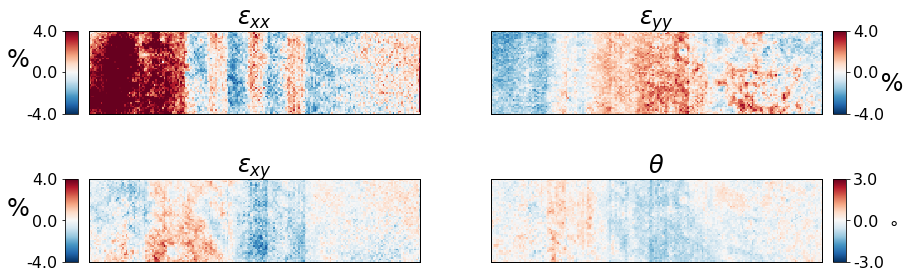

In [32]:
# Get new reference lattice vectors
mask[:] = False
mask[x0:xf,y0:yf] = True

bragg_peaks.get_strain_from_reference_g1g2(mask)

strainmap_ROI = bragg_peaks.get_rotated_strain_map(mode = 'reference')

# plot the 4 components of the strain tensor
fig,axs = py4DSTEM.visualize.show_strain(
    strainmap_ROI,
    vrange_exx = [-4.0, 4.0],
    vrange_theta = [-3.0, 3.0],
    ticknumber = 3,
    axes_plots = (),
    bkgrd = False,
    figsize = (14,5),
    returnfig = True
)

# Plot line traces for the mean strain values

In [33]:
import h5py
# Now load the experimental strain profile measured from the EELS composition map

eels_data = h5py.File(file_path_compare,'r') 
imGe = np.asarray(eels_data['imGe'])
imSi = np.asarray(eels_data['imSi'])
strain_exp = 1.275*np.asarray(eels_data['strain'])
wGe = np.asarray(eels_data['wGe'])
wSi = np.asarray(eels_data['wSi'])

In [34]:
# Estimated strain profile from STEM-EELS
probe_step_x_ = np.arange(0,strainmap_ROI.data.shape[1])
strain_ideal_e_xx = np.mean(strain_exp, axis=0)
strain_ideal_e_yy = np.zeros_like(probe_step_x_)

In [35]:
import matplotlib.pyplot as plt

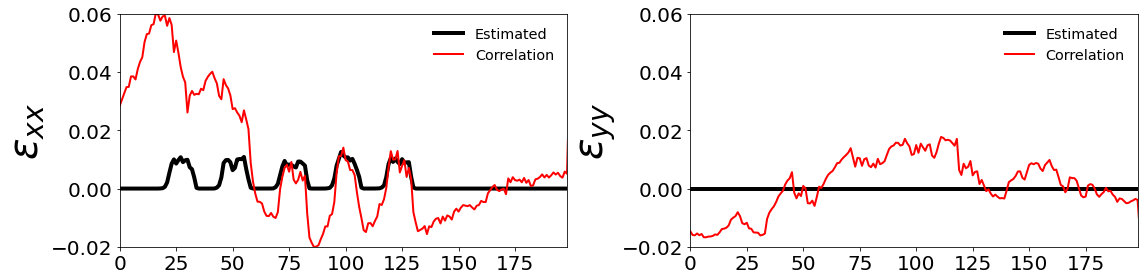

In [36]:
# Get mean E_xx and E_yy strain maps along the perpendicular to growth direction
strain_mean_e_xx_corr = np.mean(strainmap_ROI.get_slice('e_xx').data,axis=0)
strain_mean_e_yy_corr = np.mean(strainmap_ROI.get_slice('e_yy').data,axis=0)

# Plotting
fig, axs = plt.subplots(1,2,figsize=(16,4))

# strain along x direction
axs[0].plot(
    probe_step_x_, 
    np.roll(strain_ideal_e_xx, -3),
    color = 'k',
    linestyle = '-', linewidth = 4, label = 'Estimated');
axs[0].plot(
    probe_step_x_, 
    strain_mean_e_xx_corr,
    color = 'r', linewidth = 2, label = 'Correlation')
axs[0].set_xlim(0,198)
axs[0].set_ylim(-0.02,0.06)

# strain along y direction
axs[1].plot(
    probe_step_x_, 
    np.roll(strain_ideal_e_yy,-10),
    color = 'k',
    linestyle = '-', linewidth = 4, label = 'Estimated');
axs[1].plot(
    probe_step_x_, 
    strain_mean_e_yy_corr,
    color = 'r', linewidth = 2, label = 'Correlation')
axs[1].set_xlim(0,198)
axs[1].set_ylim(-0.02,0.06)

axs[0].legend(frameon = False, fontsize = 'x-large')
axs[1].legend(frameon = False, fontsize = 'x-large')
axs[0].locator_params(axis = "y", nbins = 4)
axs[1].locator_params(axis = "y", nbins = 4)
axs[0].locator_params(axis = "x", nbins = 8)
axs[1].locator_params(axis = "x", nbins = 8)
axs[0].tick_params(axis = 'both', which = 'major', labelsize = 20)
axs[1].tick_params(axis = 'both', which = 'major', labelsize = 20)
#ax.set_yticklabels(xlabels, fontsize= )
axs[0].set_ylabel(r'$\epsilon_{xx}$', fontsize = 40)
axs[1].set_ylabel(r'$\epsilon_{yy}$', fontsize = 40)
plt.tight_layout()
#fig.savefig('./paper_figs/strain_profile_exp_thin.pdf', dpi=600)
plt.show()

Note that this strain map looks pretty bad, due to the thickness of the sample and the large binning factor we used here.  The original resolution data produces much better strain maps.